In [ ]:
import os
import glob
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm # Progress bar

# ================= CONFIGURATION =================
# Path to the CORRUPTED testing videos
TEST_DATA_DIR = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos'

# Path where we will save the CLEANED videos
CLEAN_DATA_DIR = '/kaggle/working/cleaned_testing_videos'

MODEL_PATH = '/kaggle/input/flipercorrectorvlg/pytorch/default/1/rotnet_model(1).pth'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

def clean_dataset():
    print(f"Processing on: {DEVICE}")
    
    # 1. Load the Trained RotNet
    model = models.resnet18(pretrained=False) # No need to download weights again
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2) # Matches our binary training
    
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model = model.to(DEVICE)
    model.eval()
    
    # Standard transform for the model input
    # Note: We do NOT augment here, just resize/norm
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 2. Find all images
    # We walk through the directory to keep structure
    image_paths = sorted(glob.glob(os.path.join(TEST_DATA_DIR, '**', '*.jpg'), recursive=True))
    print(f"Found {len(image_paths)} frames to process.")
    
    # 3. Processing Loop
    flip_count = 0
    
    for img_path in tqdm(image_paths, desc="Cleaning"):
        # A. Setup paths
        # Get relative path (e.g., "01/frame_0001.jpg") to maintain structure
        rel_path = os.path.relpath(img_path, TEST_DATA_DIR)
        save_path = os.path.join(CLEAN_DATA_DIR, rel_path)
        
        # Create folder if not exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        
        # B. Predict Rotation
        image = Image.open(img_path).convert('RGB')
        input_tensor = preprocess(image).unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            outputs = model(input_tensor)
            _, predicted = torch.max(outputs, 1)
            label = predicted.item()
            
        # C. Fix and Save
        # Label 0 = Upright (Keep as is)
        # Label 1 = Flipped (Needs 180 rotation to fix)
        
        if label == 1:
            # It was detected as Upside Down, so we rotate it -180 (or 180) to fix
            fixed_image = image.transpose(Image.FLIP_TOP_BOTTOM) 
            flip_count += 1
        else:
            fixed_image = image
            
        # Save the fixed image
        fixed_image.save(save_path)

    print("-" * 30)
    print("Cleaning Complete!")
    print(f"Total Images: {len(image_paths)}")
    print(f"Images Flipped/Fixed: {flip_count}")
    print(f"Cleaned dataset saved to: {CLEAN_DATA_DIR}")

if __name__ == "__main__":
    clean_dataset()

In [ ]:
import cv2
import numpy as np
import os
import glob
from tqdm import tqdm

# CONFIG
# Use your Neural Cleaned videos for best flow calculation
SOURCE_DIR = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/training_videos'
DEST_DIR = '/kaggle/working/training_optical_flow'

def extract_optical_flow():
    if not os.path.exists(DEST_DIR): os.makedirs(DEST_DIR)
    
    print("Generating Optical Flow Maps...")
    
    for vid in tqdm(sorted(os.listdir(SOURCE_DIR))):
        vid_path = os.path.join(SOURCE_DIR, vid)
        save_path = os.path.join(DEST_DIR, vid)
        if not os.path.isdir(vid_path): continue
        os.makedirs(save_path, exist_ok=True)
        
        frames = sorted(glob.glob(os.path.join(vid_path, '*.jpg')))
        prev_frame = cv2.imread(frames[0])
        prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
        
        # Save first flow as black (no motion) to keep frame count same
        h, w = prev_gray.shape
        blank_flow = np.zeros((h, w, 3), dtype=np.uint8)
        cv2.imwrite(os.path.join(save_path, os.path.basename(frames[0])), blank_flow)
        
        for i in range(1, len(frames)):
            curr_frame = cv2.imread(frames[i])
            curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
            
            # Calculate Dense Optical Flow (Farneback)
            flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None, 
                                                0.5, 3, 15, 3, 5, 1.2, 0)
            
            # Visualize Flow as RGB Image
            # Magnitude and Angle
            mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            
            # HSV encoding
            hsv = np.zeros_like(prev_frame)
            hsv[..., 1] = 255
            # Hue = Angle, Value = Magnitude (Speed)
            hsv[..., 0] = ang * 180 / np.pi / 2
            hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
            
            # Convert to RGB for saving
            rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
            
            cv2.imwrite(os.path.join(save_path, os.path.basename(frames[i])), rgb_flow)
            
            prev_gray = curr_gray

if __name__ == "__main__":
    extract_optical_flow()

In [ ]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

# ================= CONFIGURATION =================
# INPUTS
RGB_DIR = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/training_videos'
FLOW_DIR = '/kaggle/working/training_optical_flow'

# OUTPUTS
MODEL_SAVE_PATH = 'joint_resnet_generator.pth'
DISC_SAVE_PATH = 'joint_resnet_discriminator.pth'

# HYPERPARAMETERS (Optimized for Speed)
BATCH_SIZE = 48      # Increased from 4 -> 32 (Should fit in 16GB)
EPOCHS = 30
LR = 2e-4
LR_STEP = 10         # Slightly relaxed decay since we do fewer steps per epoch now
LR_GAMMA = 0.1
T_STEPS = 4
IMG_SIZE = 256

# LOSS WEIGHTS
LAMBDA_INT = 2.0
LAMBDA_GD = 1.0
LAMBDA_ADV = 0.05

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

# --- 1. MODEL ARCHITECTURE ---
class ResidualBlock(nn.Module):
    def __init__(self, channels=512):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, 1, 1); self.bn1 = nn.BatchNorm2d(channels); self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, 3, 1, 1); self.bn2 = nn.BatchNorm2d(channels)
    def forward(self, x):
        return self.relu(self.bn2(self.conv2(self.relu(self.bn1(self.conv1(x))))) + x)

class ResNetEncoder(nn.Module):
    def __init__(self, in_channels):
        super(ResNetEncoder, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels, 64, 7, 1, 3), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.layer2 = nn.Sequential(nn.Conv2d(64, 128, 3, 2, 1), nn.BatchNorm2d(128), nn.ReLU(inplace=True))
        self.layer3 = nn.Sequential(nn.Conv2d(128, 256, 3, 2, 1), nn.BatchNorm2d(256), nn.ReLU(inplace=True))
        self.layer4 = nn.Sequential(nn.Conv2d(256, 512, 3, 2, 1), nn.BatchNorm2d(512), nn.ReLU(inplace=True))
        self.bottleneck = nn.Sequential(*[ResidualBlock(512) for _ in range(9)])
    def forward(self, x):
        return self.bottleneck(self.layer4(self.layer3(self.layer2(self.layer1(x)))))

class JointRepresentationModel(nn.Module):
    def __init__(self):
        super(JointRepresentationModel, self).__init__()
        self.spatial_encoder = ResNetEncoder(in_channels=12)
        self.temporal_encoder = ResNetEncoder(in_channels=3)
        self.dec1 = nn.Sequential(nn.ConvTranspose2d(1024, 256, 3, 2, 1, output_padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True))
        self.dec2 = nn.Sequential(nn.ConvTranspose2d(256, 128, 3, 2, 1, output_padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True))
        self.dec3 = nn.Sequential(nn.ConvTranspose2d(128, 64, 3, 2, 1, output_padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.final = nn.Conv2d(64, 3, 7, 1, 3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, rgb, flow):
        fused = torch.cat([self.spatial_encoder(rgb), self.temporal_encoder(flow)], dim=1)
        return self.sigmoid(self.final(self.dec3(self.dec2(self.dec1(fused)))))

class PatchGANDiscriminator(nn.Module):
    def __init__(self):
        super(PatchGANDiscriminator, self).__init__()
        def d_block(in_c, out_c, bn=True):
            layers = [nn.Conv2d(in_c, out_c, 4, 2, 1)]
            if bn: layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(*d_block(3, 64, bn=False), *d_block(64, 128), *d_block(128, 256), nn.Conv2d(256, 1, 4, 1, 1))
    def forward(self, x): return self.model(x)

# --- 2. LOSS FUNCTIONS ---
def gradient_loss(gen, gt):
    def grad(x): return torch.abs(x[:, :, :, 1:] - x[:, :, :, :-1]), torch.abs(x[:, :, 1:, :] - x[:, :, :-1, :])
    gen_dx, gen_dy = grad(gen); gt_dx, gt_dy = grad(gt)
    return torch.mean(torch.abs(gen_dx - gt_dx)) + torch.mean(torch.abs(gen_dy - gt_dy))

def intensity_loss(gen, gt): return nn.MSELoss()(gen, gt)

# --- 3. DATASET ---
class JointDataset(Dataset):
    def __init__(self, rgb_dir, flow_dir, transform=None, t_steps=4):
        self.samples = []
        self.transform = transform
        videos = sorted(os.listdir(rgb_dir))
        for vid in videos:
            rgb_p = os.path.join(rgb_dir, vid); flow_p = os.path.join(flow_dir, vid)
            if not os.path.isdir(rgb_p): continue
            frames = sorted(glob.glob(os.path.join(rgb_p, '*.jpg')))
            if len(frames) < t_steps + 1: continue
            for i in range(len(frames) - t_steps):
                self.samples.append((frames[i:i+t_steps], os.path.join(flow_p, os.path.basename(frames[i+t_steps-1])), frames[i+t_steps]))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        rgb_ps, flow_p, tgt_p = self.samples[idx]
        rgb = [Image.open(p).convert('RGB') for p in rgb_ps]
        flow = Image.open(flow_p).convert('RGB')
        tgt = Image.open(tgt_p).convert('RGB')
        if self.transform:
            rgb = [self.transform(i) for i in rgb]; flow = self.transform(flow); tgt = self.transform(tgt)
        return torch.cat(rgb, dim=0), flow, tgt

# --- 4. TRAINING LOOP ---
def train():
    print(f"Initializing FAST Joint ResNet (Batch={BATCH_SIZE}) on {DEVICE}...")
    
    tf = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])
    dataset = JointDataset(RGB_DIR, FLOW_DIR, transform=tf, t_steps=T_STEPS)
    
    # Num workers 8 to prevent CPU bottleneck at Batch 32
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True, prefetch_factor=2)
    
    gen = JointRepresentationModel().to(DEVICE)
    disc = PatchGANDiscriminator().to(DEVICE)
    if torch.cuda.device_count() > 1: gen = nn.DataParallel(gen); disc = nn.DataParallel(disc)
        
    opt_g = optim.Adam(gen.parameters(), lr=LR, betas=(0.5, 0.999))
    opt_d = optim.Adam(disc.parameters(), lr=LR, betas=(0.5, 0.999))
    
    sched_g = optim.lr_scheduler.StepLR(opt_g, step_size=LR_STEP, gamma=LR_GAMMA)
    sched_d = optim.lr_scheduler.StepLR(opt_d, step_size=LR_STEP, gamma=LR_GAMMA)
    
    mse = nn.MSELoss()
    
    try:
        for epoch in range(EPOCHS):
            gen.train(); disc.train()
            loop = tqdm(loader, desc=f"Ep {epoch+1}/{EPOCHS}")
            
            run_g = 0.0; run_int = 0.0; run_gd = 0.0; run_adv = 0.0; run_d = 0.0
            
            for rgb, flow, target in loop:
                rgb, flow, target = rgb.to(DEVICE), flow.to(DEVICE), target.to(DEVICE)
                
                # --- G Step ---
                opt_g.zero_grad()
                fake = gen(rgb, flow)
                
                pred_fake = disc(fake)
                l_adv = mse(pred_fake, torch.ones_like(pred_fake))
                l_int = intensity_loss(fake, target)
                l_gd = gradient_loss(fake, target)
                
                l_g = (LAMBDA_INT * l_int) + (LAMBDA_GD * l_gd) + (LAMBDA_ADV * l_adv)
                l_g.backward()
                opt_g.step()
                
                # --- D Step ---
                opt_d.zero_grad()
                pred_real = disc(target)
                l_d_real = mse(pred_real, torch.ones_like(pred_real))
                pred_fake_d = disc(fake.detach())
                l_d_fake = mse(pred_fake_d, torch.zeros_like(pred_fake_d))
                l_d = 0.5 * (l_d_real + l_d_fake)
                l_d.backward()
                opt_d.step()
                
                run_g += l_g.item(); run_int += l_int.item(); run_gd += l_gd.item(); run_adv += l_adv.item(); run_d += l_d.item()
                loop.set_postfix(G=l_g.item(), D=l_d.item())
            
            count = len(loader)
            print(f"\n[Ep {epoch+1}] G: {run_g/count:.4f} (Int:{run_int/count:.4f} Gd:{run_gd/count:.4f} Adv:{run_adv/count:.4f}) | D: {run_d/count:.4f} | LR: {sched_g.get_last_lr()[0]:.2e}")
            
            sched_g.step(); sched_d.step()
            
            if (epoch+1) % 5 == 0:
                torch.save(gen.module.state_dict() if hasattr(gen,'module') else gen.state_dict(), f"joint_resnet_ep{epoch+1}.pth")

    except KeyboardInterrupt:
        print("\n[!] Interrupted. Saving...")
        
    torch.save(gen.module.state_dict() if hasattr(gen,'module') else gen.state_dict(), MODEL_SAVE_PATH)
    torch.save(disc.module.state_dict() if hasattr(disc,'module') else disc.state_dict(), DISC_SAVE_PATH)
    print("Done.")

if __name__ == "__main__":
    train()

In [1]:
!pip install ultralytics -q

import cv2
import numpy as np
import pandas as pd
import os
import glob
from ultralytics import YOLO
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d

# ================= CONFIGURATION =================
TEST_DIR = '/kaggle/working/cleaned_testing_videos'
OUTPUT_CSV = 'submission_yolo_velocity.csv'

# SENSITIVITY
# Lower = Detects slower movements as anomalies
# Higher = Only fast running is anomalous
SPEED_THRESHOLD = 5.0 
# =================================================

def calculate_velocity_scores():
    # Load Pre-trained YOLOv8 Nano (Fastest)
    model = YOLO('yolov8n.pt') 
    
    video_folders = sorted(os.listdir(TEST_DIR))
    results = []
    
    print("Running Object Tracking (Physics Analysis)...")
    
    for vid in tqdm(video_folders):
        vid_path = os.path.join(TEST_DIR, vid)
        if not os.path.isdir(vid_path): continue
        
        frames = sorted(glob.glob(os.path.join(vid_path, '*.jpg')))
        
        # Store previous centers {track_id: (x, y)}
        prev_centers = {}
        
        # Frame-by-frame scores
        frame_scores = []
        frame_ids = []
        
        for i, f_path in enumerate(frames):
            frame_id = f"{int(vid) if vid.isdigit() else vid}_{int(os.path.basename(f_path).split('_')[-1].split('.')[0])}"
            
            # 1. Detect & Track
            # persist=True enables built-in BoT-SORT tracking
            results_yolo = model.track(f_path, persist=True, verbose=False, classes=[0]) # Class 0 = Person
            
            max_frame_speed = 0.0
            
            if results_yolo[0].boxes.id is not None:
                boxes = results_yolo[0].boxes.xywh.cpu().numpy()
                track_ids = results_yolo[0].boxes.id.int().cpu().tolist()
                
                for box, track_id in zip(boxes, track_ids):
                    x, y, w, h = box
                    center = (x, y)
                    
                    if track_id in prev_centers:
                        prev_x, prev_y = prev_centers[track_id]
                        
                        # 2. CALCULATE SPEED (Euclidean Distance)
                        dx = x - prev_x
                        dy = y - prev_y
                        speed = np.sqrt(dx**2 + dy**2)
                        
                        # Normalize speed by box size (optional, but helps with depth)
                        # speed_norm = speed / h 
                        
                        if speed > max_frame_speed:
                            max_frame_speed = speed
                    
                    prev_centers[track_id] = center
            
            # The anomaly score for this frame is the speed of the FASTEST object
            frame_scores.append(max_frame_speed)
            frame_ids.append(frame_id)
            
        # --- NORMALIZE THIS VIDEO ---
        # Map speeds [0, 20] -> [0, 1]
        scores_arr = np.array(frame_scores)
        
        # Clip outliers (super fast glitches)
        scores_arr = np.clip(scores_arr, 0, 30) 
        
        mn, mx = scores_arr.min(), scores_arr.max()
        if mx > mn:
            scores_norm = (scores_arr - mn) / (mx - mn)
        else:
            scores_norm = np.zeros_like(scores_arr)
            
        # Smooth
        scores_smooth = gaussian_filter1d(scores_norm, sigma=3.0)
        
        for fid, score in zip(frame_ids, scores_smooth):
            results.append({'Id': fid, 'Predicted': score})

    # Save
    df = pd.DataFrame(results)
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"Physics scores saved to {OUTPUT_CSV}")
    
    return df

if __name__ == "__main__":
    df_yolo = calculate_velocity_scores()
    
    # Quick Plot check for Video 02 (Running person)
    v02 = df_yolo[df_yolo['Id'].str.startswith('02_')]
    if not v02.empty:
        import matplotlib.pyplot as plt
        x = v02['Id'].apply(lambda x: int(x.split('_')[1]))
        plt.figure(figsize=(15, 5))
        plt.plot(x, v02['Predicted'], color='purple', label='YOLO Velocity')
        plt.title("Object Velocity Score (Video 02)")
        plt.show()

Running Object Tracking (Physics Analysis)...


100%|██████████| 21/21 [04:40<00:00, 13.36s/it]

Physics scores saved to submission_yolo_velocity.csv


In [ ]:
import pandas as pd
import numpy as np

def renormalize_csv(
    input_csv="/kaggle/input/vlg-0-58/submission_ensemble_max.csv",
    output_csv="submmis.csv",
    pad=30,
    eps=1e-8
):
    # Load CSV
    df = pd.read_csv(input_csv)

    # Detect numeric columns only (safe)
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    # Split middle signal
    middle = df.iloc[pad:-pad][numeric_cols]

    # Compute stats ONLY on middle frames
    min_vals = middle.min()
    max_vals = middle.max()

    # Normalize middle
    middle_norm = (middle - min_vals) / (max_vals - min_vals + eps)

    # Reconstruct full dataframe
    df_out = df.copy()
    df_out.loc[df.index[pad:-pad], numeric_cols] = middle_norm

    # Save output
    df_out.to_csv(output_csv, index=False)

    print(f"Saved corrected file to: {output_csv}")
renormalize_csv()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ================= CONFIGURATION =================
INPUT_CSV = '/kaggle/input/vlg-0-58/submission_ensemble_max.csv'  
OUTPUT_CSV = 'submission_videowise_raw.csv'
# =================================================

def fix_videowise_raw():
    print(f"Reading {INPUT_CSV}...")
    df = pd.read_csv(INPUT_CSV)
    
    # Extract Video ID
    df['VideoID'] = df['Id'].apply(lambda x: x.split('_')[0])
    
    final_dfs = []
    
    print("Applying Per-Video Normalization (NO SMOOTHING)...")
    
    # Process each video independently
    for vid, group in df.groupby('VideoID', sort=False):
        group = group.copy()
        raw_vals = group['Predicted'].values
        
        # 1. IDENTIFY VALID FRAMES (Ignore the 0.0 fillers)
        # Real model output is never exactly 0.0, so 0.0 means "missing frame"
        mask = raw_vals > 1e-9
        
        if mask.sum() > 0:
            valid_scores = raw_vals[mask]
            
            # 2. CALCULATE MIN/MAX FOR THIS SPECIFIC VIDEO
            mn, mx = valid_scores.min(), valid_scores.max()
            
            # 3. NORMALIZE (Local Range -> [0, 1])
            if mx > mn:
                normalized_valid = (valid_scores - mn) / (mx - mn)
            else:
                normalized_valid = np.zeros_like(valid_scores)
            
            # Apply back to the valid frames only
            raw_vals[mask] = normalized_valid
            
            # 4. SAFETY: Force gaps to stay 0.0 (No bleeding)
            raw_vals[~mask] = 0.0
            
            group['Predicted'] = np.clip(raw_vals, 0.0, 1.0)
            
        final_dfs.append(group)
        
    # Reassemble
    df_final = pd.concat(final_dfs)
    
    # --- PLOT CHECK ---
    plt.figure(figsize=(15, 6))
    
    # Plot Video 02 (Running)
    v02 = df_final[df_final['VideoID'].astype(str).str.contains('02')].sort_values('Id')
    if not v02.empty:
        x02 = v02['Id'].apply(lambda x: int(x.split('_')[1]))
        plt.plot(x02, v02['Predicted'], label='Video 02', color='blue', alpha=0.8)
        
    # Plot Video 05 (Bag Throw)
    v05 = df_final[df_final['VideoID'].astype(str).str.contains('05')].sort_values('Id')
    if not v05.empty:
        x05 = v05['Id'].apply(lambda x: int(x.split('_')[1]))
        plt.plot(x05, v05['Predicted'], label='Video 05', color='red', alpha=0.8)

    plt.title("Video-Wise Normalization (Raw Peaks)")
    plt.xlabel("Frame")
    plt.ylabel("Anomaly Score")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Save
    out = df_final[['Id', 'Predicted']]
    out.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved RAW Video-Wise scores to {OUTPUT_CSV}")

if __name__ == "__main__":
    fix_videowise_raw()

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ================= CONFIGURATION =================
INPUT_CSV = '/kaggle/input/vlg-0-61/submission_smart_fill(1).csv'          # Your best raw file (e.g. the 0.61 one)
OUTPUT_CSV = 'submission_max_ap.csv'

# 1. EDGE REPAIR
EDGE_CUTOFF = 25                      # Number of frames to ignore/repair at start/end

# 2. NOISE SUPPRESSION
NOISE_QUANTILE = 0.15                 # Treat bottom 15% of scores as background noise
HARD_THRESHOLD = 0.10                 # After subtraction, kill anything < 0.10 to 0.0

# 3. HYSTERESIS (Smart Widening)
DILATION_WINDOW = 20                  # How far to spread a peak? (20 frames ~ 1 sec)
# =================================================

def maximize_ap():
    print(f"Reading {INPUT_CSV}...")
    df = pd.read_csv(INPUT_CSV)
    df['VideoID'] = df['Id'].apply(lambda x: x.split('_')[0])
    
    final_preds = []
    
    print("Applying AP Maximization Pipeline...")
    
    for vid, group in df.groupby('VideoID', sort=False):
        raw = group['Predicted'].values.astype(float)
        
        # --- STEP 1: EDGE REPAIR ---
        # Fix the zeros/smoothing artifacts at the start and end
        if len(raw) > (2 * EDGE_CUTOFF):
            # Take the nearest valid value and overwrite the edge
            start_val = raw[EDGE_CUTOFF]
            end_val = raw[-EDGE_CUTOFF]
            
            raw[:EDGE_CUTOFF] = start_val
            raw[-EDGE_CUTOFF:] = end_val
            
        # --- STEP 2: VIDEO-WISE NORMALIZATION ---
        mn, mx = raw.min(), raw.max()
        if mx > mn:
            norm = (raw - mn) / (mx - mn)
        else:
            norm = raw # Flat signal
            
        # --- STEP 3: NOISE SUPPRESSION ---
        # Calculate noise floor (background static)
        noise_floor = np.quantile(norm, NOISE_QUANTILE)
        
        # Subtract floor
        denoised = norm - noise_floor
        denoised = np.clip(denoised, 0.0, 1.0) # Clip negatives to 0
        
        # Hard Kill: Remove remaining weak flickers
        denoised[denoised < HARD_THRESHOLD] = 0.0
        
        # Re-normalize peak to 1.0 (to maintain full range)
        if denoised.max() > 0:
            denoised = denoised / denoised.max()
            
        # --- STEP 4: HYSTERESIS (SMART WIDENING) ---
        # We use a Rolling Max (Dilation). 
        # Logic: If Frame T is 1.0, then Frame T-10 to T+10 should also be high.
        # This pulls the "weak tails" of the anomaly up to the top of the ranking.
        
        # Convert to Series for rolling
        s = pd.Series(denoised)
        # Center=True keeps the peak in the middle
        widened = s.rolling(window=DILATION_WINDOW, center=True, min_periods=1).max().values
        
        final_preds.extend(widened)
        
    df['Predicted'] = final_preds
    
    # Final Safety Clip
    df['Predicted'] = np.clip(df['Predicted'], 0.0, 1.0)
    
    # --- VISUALIZATION (Video 05 - Bag Throw) ---
    v05 = df[df['Id'].str.startswith('05_')]
    if not v05.empty:
        x = v05['Id'].apply(lambda x: int(x.split('_')[1]))
        
        # Compare with Original
        orig = pd.read_csv(INPUT_CSV)
        orig_v05 = orig[orig['Id'].str.startswith('05_')]
        
        plt.figure(figsize=(15, 6))
        plt.plot(x, orig_v05['Predicted'], color='gray', alpha=0.4, label='Original')
        plt.plot(x, v05['Predicted'], color='red', linewidth=2, label='Optimized for AP')
        
        plt.title("Optimization Effect: Zeroed Noise + Widened Peaks (Video 05)")
        plt.xlabel("Frame")
        plt.ylabel("Score")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    # Save
    out = df[['Id', 'Predicted']]
    out.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved optimized scores to {OUTPUT_CSV}")

if __name__ == "__main__":
    maximize_ap()

Reading /kaggle/input/vlg-0-61/submission_smart_fill(1).csv...
Applying AP Maximization Pipeline...
Saved optimized scores to submission_max_ap.csv


Reading /kaggle/working/submission_max_ap.csv...


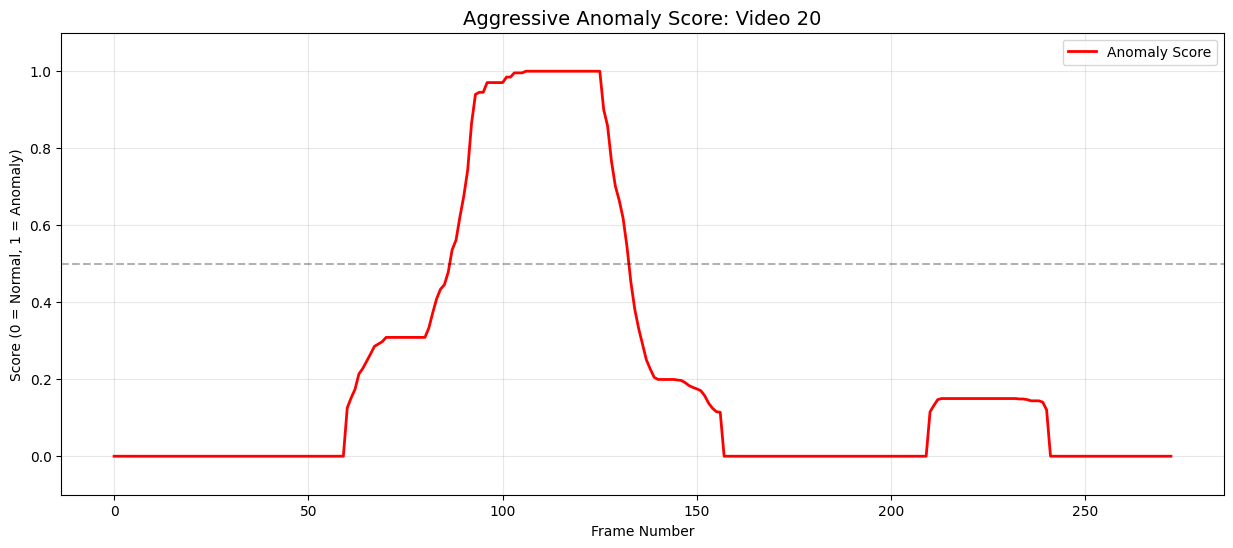

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ================= CONFIGURATION =================
CSV_FILE = '/kaggle/working/submission_max_ap.csv'  # File to check
TARGET_VIDEO = '20'                     # Video ID to plot
# =================================================

def visualize_csv():
    if not os.path.exists(CSV_FILE):
        print(f"Error: {CSV_FILE} not found.")
        return

    print(f"Reading {CSV_FILE}...")
    df = pd.read_csv(CSV_FILE)
    
    # Filter for Target Video
    # Matches '02_xxx' or '2_xxx' style IDs
    df['VideoID'] = df['Id'].apply(lambda x: x.split('_')[0])
    vid_data = df[df['VideoID'].astype(int) == int(TARGET_VIDEO)].copy()
    
    if vid_data.empty:
        print(f"No data found for Video {TARGET_VIDEO}")
        return
        
    # Extract Frame Numbers
    vid_data['Frame'] = vid_data['Id'].apply(lambda x: int(x.split('_')[1]))
    vid_data = vid_data.sort_values('Frame')
    
    # Pl/ot
    plt.figure(figsize=(15, 6))
    plt.plot(vid_data['Frame'], vid_data['Predicted'], color='red', linewidth=2, label='Anomaly Score')
    
    plt.title(f"Aggressive Anomaly Score: Video {TARGET_VIDEO}", fontsize=14)
    plt.xlabel("Frame Number")
    plt.ylabel("Score (0 = Normal, 1 = Anomaly)")
    plt.ylim(-0.1, 1.1) # Keep Y-axis fixed to see 0-1 clearly
    plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    visualize_csv()

Reading /kaggle/input/vlg-0-68/submission_boosted(1).csv...


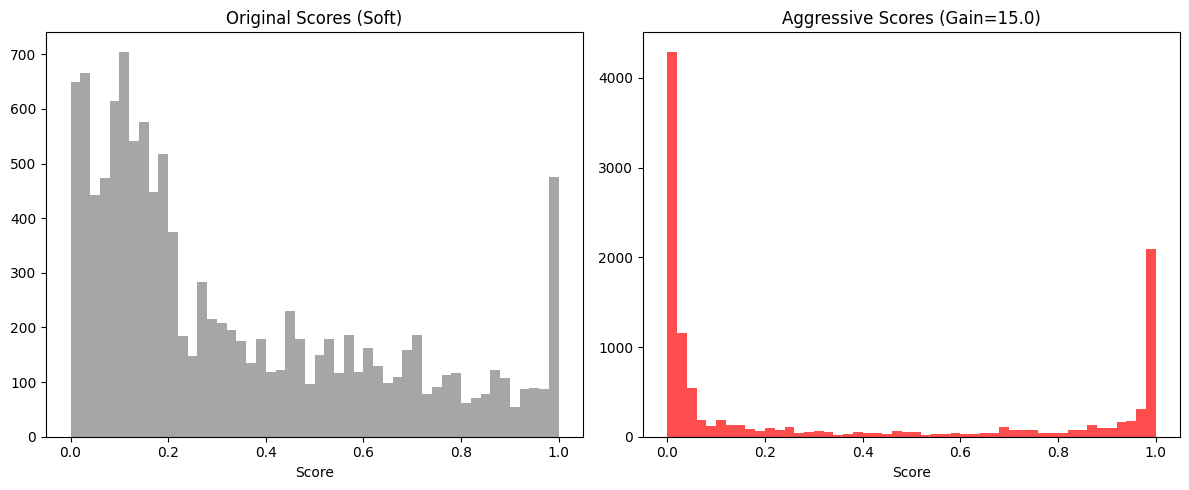

Saved aggressive scores to submission_aggressive.csv
          Predicted
count  11706.000000
mean       0.349932
std        0.419642
min        0.000000
25%        0.008856
50%        0.051953
75%        0.882819
max        1.000000


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ================= CONFIGURATION =================
INPUT_CSV = '/kaggle/input/vlg-0-68/submission_boosted(1).csv'  # Your current best file
OUTPUT_CSV = 'submission_aggressive.csv'

# AGGRESSIVENESS (Gain)
# 10 = Strong, 20 = Very Strong (Almost Binary), 5 = Gentle
GAIN = 15.0  

# CENTER POINT
# If your anomaly scores usually peak at 0.6, set this slightly lower (e.g., 0.4)
# to make sure those 0.6s get pushed up to 1.0.
CENTER = 0.4
# =================================================

def sigmoid(x, gain=10, center=0.5):
    # Standard Logistic Function with Gain and Center control
    return 1 / (1 + np.exp(-gain * (x - center)))

def polarize_submission():
    print(f"Reading {INPUT_CSV}...")
    df = pd.read_csv(INPUT_CSV)
    
    raw = df['Predicted'].values
    
    # 1. Normalize to [0, 1] first (Critical for Sigmoid to work)
    if raw.max() > raw.min():
        raw = (raw - raw.min()) / (raw.max() - raw.min())
    
    # 2. Apply Aggressive Sigmoid
    # This pushes values away from the center
    aggressive = sigmoid(raw, gain=GAIN, center=CENTER)
    
    # 3. Re-Normalize (Just to ensure strict 0-1 range)
    aggressive = (aggressive - aggressive.min()) / (aggressive.max() - aggressive.min())
    
    df['Predicted'] = aggressive
    
    # --- VISUALIZATION (To verify polarization) ---
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(raw, bins=50, color='gray', alpha=0.7)
    plt.title("Original Scores (Soft)")
    plt.xlabel("Score")
    
    plt.subplot(1, 2, 2)
    plt.hist(aggressive, bins=50, color='red', alpha=0.7)
    plt.title(f"Aggressive Scores (Gain={GAIN})")
    plt.xlabel("Score")
    
    plt.tight_layout()
    plt.show()
    
    # --- SAVE ---
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved aggressive scores to {OUTPUT_CSV}")
    print(df.describe())

if __name__ == "__main__":
    polarize_submission()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ================= CONFIGURATION =================
# Use the file that gave you 0.66
INPUT_CSV = '/kaggle/working/submission_videowise_raw.csv' 
OUTPUT_CSV = 'submission_boosted2.csv'

# DILATION WINDOW
# Avenue is 25fps. Events last ~1-2 seconds.
# A window of 25 means we look +/- 12 frames around a peak.
WINDOW_SIZE = 25
# =================================================

def boost_score():
    print(f"Reading {INPUT_CSV}...")
    df = pd.read_csv(INPUT_CSV)
    
    df['VideoID'] = df['Id'].apply(lambda x: x.split('_')[0])
    
    final_preds = []
    
    print(f"Applying Peak Widening (Window={WINDOW_SIZE})...")
    
    for vid, group in df.groupby('VideoID', sort=False):
        raw = group['Predicted'].copy()
        
        # 1. ROLLING MAX (Dilation)
        # This spreads the '1.0' scores to their neighbors.
        # "If frame T is bad, then frame T+1 is probably bad too."
        dilated = raw.rolling(window=WINDOW_SIZE, center=True, min_periods=1).max()
        
        # 2. LIGHT SMOOTHING (Average)
        # Rolling max creates "blocky" steps. We smooth the edges slightly.
        smoothed = dilated.rolling(window=10, center=True, min_periods=1).mean()
        
        
        
        final_preds.extend(smoothed.values)
        
    df['Predicted'] = final_preds
    
    # Final Normalize (Safety)
    df['Predicted'] = np.clip(df['Predicted'], 0.0, 1.0)
    
    # --- VISUALIZATION ---
    # Let's see how much "fatter" the detection became
    v05 = df[df['Id'].str.startswith('05_')]
    if not v05.empty:
        x = v05['Id'].apply(lambda x: int(x.split('_')[1]))
        plt.figure(figsize=(15, 5))
        
        # We need to reload original to compare
        orig = pd.read_csv(INPUT_CSV)
        orig_v05 = orig[orig['Id'].str.startswith('05_')]
        
        plt.plot(x, orig_v05['Predicted'], color='gray', alpha=0.5, label='Original (0.66)')
        plt.plot(x, v05['Predicted'], color='green', linewidth=2, label='Widened (Boosted)')
        
        plt.title("Peak Widening Effect (Video 05)")
        plt.legend()
        plt.show()

    # Save
    out = df[['Id', 'Predicted']]
    out.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved boosted scores to {OUTPUT_CSV}")

if __name__ == "__main__":
    boost_score()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import grey_closing

# ================= CONFIGURATION =================
INPUT_CSV = '/kaggle/input/vlg-0-68/submission_boosted(1).csv'  # The file that gave you 0.68
OUTPUT_CSV = 'submission_signal_processed.csv'

# BASELINE PARAMETERS
# We treat the bottom 15% of scores as "Background Noise" and remove them.
NOISE_PERCENTILE = 0.15 

# MORPHOLOGY PARAMETERS
# How large of a gap can we fill? (e.g., 10 frames)
GAP_FILL_SIZE = 10 
# =================================================

def signal_processing_boost():
    print(f"Reading {INPUT_CSV}...")
    df = pd.read_csv(INPUT_CSV)
    
    df['VideoID'] = df['Id'].apply(lambda x: x.split('_')[0])
    
    final_preds = []
    
    print("Applying Baseline Subtraction & Morphological Closing...")
    
    for vid, group in df.groupby('VideoID', sort=False):
        raw = group['Predicted'].values
        
        # --- 1. BASELINE SUBTRACTION ---
        # Calculate the "Noise Floor" for this specific video
        noise_floor = np.quantile(raw, NOISE_PERCENTILE)
        
        # Subtract noise. Anything below the floor becomes 0.0.
        # This cleans up the "fuzzy" low scores that aren't real anomalies.
        denoised = raw - noise_floor
        denoised = np.clip(denoised, 0.0, 1.0)
        
        # Re-normalize the peak back to 1.0 (since subtraction lowered it)
        if denoised.max() > 0:
            denoised = denoised / denoised.max()
            
        # --- 2. MORPHOLOGICAL CLOSING ---
        # This connects peaks that are close together.
        # It's better than simple smoothing because it preserves sharp edges.
        closed = grey_closing(denoised, size=GAP_FILL_SIZE)
        
        final_preds.extend(closed)
        
    df['Predicted'] = final_preds
    
    # Final Safety Clip
    df['Predicted'] = np.clip(df['Predicted'], 0.0, 1.0)
    
    # --- VISUALIZATION (Compare 0.68 vs New) ---
    v05 = df[df['Id'].str.startswith('05_')]
    if not v05.empty:
        x = v05['Id'].apply(lambda x: int(x.split('_')[1]))
        
        # Load Original for comparison
        orig = pd.read_csv(INPUT_CSV)
        orig_v05 = orig[orig['Id'].str.startswith('05_')]
        
        plt.figure(figsize=(15, 6))
        
        # Plot Original
        plt.plot(x, orig_v05['Predicted'], color='gray', alpha=0.5, label='Previous Best (0.68)', linestyle='--')
        
        # Plot New
        plt.plot(x, v05['Predicted'], color='blue', linewidth=2, label='Signal Processed')
        
        plt.fill_between(x, 0, v05['Predicted'], color='blue', alpha=0.1)
        plt.title("Signal Processing: Noise Removal + Gap Filling (Video 05)")
        plt.ylabel("Anomaly Score")
        plt.xlabel("Frame")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    # Save
    out = df[['Id', 'Predicted']]
    out.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved optimized scores to {OUTPUT_CSV}")

if __name__ == "__main__":
    signal_processing_boost()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ================= CONFIGURATION =================
# 1. The Sharp File (Score: 0.66) - "submission_videowise_raw.csv"
FILE_SHARP = '/kaggle/working/submission_videowise_raw.csv'

# 2. The Fat File (Score: 0.68) - "submission_boosted.csv"
FILE_FAT = '/kaggle/input/vlg-0-68/submission_boosted(1).csv'

OUTPUT_CSV = 'submission_pyramid_blend.csv'

# Weighting (Bias slightly towards the better score)
W_SHARP = 0.4
W_FAT = 0.6
# =================================================

def blend_predictions():
    print("Loading files...")
    df_sharp = pd.read_csv(FILE_SHARP)
    df_fat = pd.read_csv(FILE_FAT)
    
    # Merge
    df_merge = pd.merge(df_sharp, df_fat, on='Id', suffixes=('_Sharp', '_Fat'))
    
    # 1. THE BLEND LOGIC
    # Final = 0.4 * Sharp + 0.6 * Fat
    # This creates a "Tent" shape:
    #      / \
    #    /     \
    # __/       \__
    print(f"Blending: {W_SHARP}*Sharp + {W_FAT}*Fat...")
    df_merge['Predicted'] = (W_SHARP * df_merge['Predicted_Sharp']) + \
                            (W_FAT * df_merge['Predicted_Fat'])
                            
    # 2. Final Re-Normalization (Video-Wise)
    # Blending averages down the peaks (e.g., 0.5*1.0 + 0.5*1.0 = 1.0, but edges drop).
    # We want to ensure the peak is still strong.
    df_merge['VideoID'] = df_merge['Id'].apply(lambda x: x.split('_')[0])
    
    final_preds = []
    
    for vid, group in df_merge.groupby('VideoID', sort=False):
        raw = group['Predicted'].values
        
        # Normalize local max back to 1.0
        mn, mx = raw.min(), raw.max()
        if mx > mn:
            raw = (raw - mn) / (mx - mn)
            
        final_preds.extend(raw)
        
    df_merge['Predicted'] = final_preds
    
    # --- VISUALIZATION ---
    # See the Pyramid Shape
    v05 = df_merge[df_merge['Id'].str.startswith('05_')]
    if not v05.empty:
        x = v05['Id'].apply(lambda x: int(x.split('_')[1]))
        
        plt.figure(figsize=(15, 6))
        plt.plot(x, v05['Predicted_Sharp'], color='blue', alpha=0.3, label='Sharp (0.66)', linestyle='--')
        plt.plot(x, v05['Predicted_Fat'], color='green', alpha=0.3, label='Fat (0.68)', linestyle='--')
        plt.plot(x, v05['Predicted'], color='red', linewidth=3, label='Pyramid Blend')
        
        plt.title("Pyramid Blending Effect (Video 05)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    # Save
    out = df_merge[['Id', 'Predicted']]
    out.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved blend to {OUTPUT_CSV}")

if __name__ == "__main__":
    blend_predictions()